In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import os
import pandas as pd

In [2]:
# dataset paths
data_train_path = './train_folder'
data_test_path = './test_folder'

# Classes
classes = os.listdir(data_train_path)
num_classes = len(classes)

print("Total number of classes: " + str(num_classes))

Total number of classes: 9


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SIZE = IMAGE_SIZE[0]

# Load the full training dataset (will be split later)
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_train_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

# Preprocessing and performance optimization
full_train_ds = full_train_ds.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Count total number of batches
total_batches = tf.data.experimental.cardinality(full_train_ds).numpy()
train_batches = int(0.9 * total_batches)
val_batches = total_batches - train_batches

# Dividir o dataset em treino (90%) e validação (10%)
train_ds = full_train_ds.take(train_batches)
valid_ds = full_train_ds.skip(train_batches)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply augmentation and normalization to training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

# Apply only normalization to validation set
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

# Split the dataset: 90% for training and 10% for validation
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_test_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

# Print dataset sizes
print("Total batches:", total_batches + tf.data.experimental.cardinality(test_ds).numpy())
print("Train batches:", train_batches)
print("Validation batches:", val_batches)
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())


Found 3271 files belonging to 9 classes.
Found 744 files belonging to 9 classes.
Total batches: 127
Train batches: 92
Validation batches: 11
Test batches: 24


In [4]:

model = Sequential([
    # 1º bloco
    layers.Resizing(SIZE, SIZE, interpolation="bilinear", input_shape=(SIZE, SIZE, 3)),
    layers.Conv2D(96, kernel_size=11, strides=4, padding='same'),
    layers.Lambda(tf.nn.local_response_normalization),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=3, strides=2),

    # 2º bloco
    layers.Conv2D(256, kernel_size=5, strides=1, padding='same'),
    layers.Lambda(tf.nn.local_response_normalization),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=3, strides=2),

    # 3º bloco
    layers.Conv2D(384, kernel_size=3, strides=1, padding='same'),
    layers.Activation('relu'),

    layers.Conv2D(384, kernel_size=3, strides=1, padding='same'),
    layers.Activation('relu'),

    layers.Conv2D(256, kernel_size=3, strides=1, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=3, strides=2),

    # Camadas densas
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


In [5]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Train model by .fit function
history = model.fit(
    train_ds,                                          # Dataset to train model
    epochs=50,                                        # Number of epochs to train
    validation_data=valid_ds                          # Validation dataset
)

Epoch 1/50
92/92 [==============================] - 156s 2s/step - loss: 2.1539 - accuracy: 0.1771 - val_loss: 2.1421 - val_accuracy: 0.1847
Epoch 2/50
92/92 [==============================] - 149s 2s/step - loss: 2.1465 - accuracy: 0.1785 - val_loss: 2.1430 - val_accuracy: 0.1591
Epoch 3/50
92/92 [==============================] - 149s 2s/step - loss: 2.1435 - accuracy: 0.1853 - val_loss: 2.1789 - val_accuracy: 0.1364
Epoch 4/50
92/92 [==============================] - 149s 2s/step - loss: 2.1371 - accuracy: 0.1874 - val_loss: 2.1546 - val_accuracy: 0.1648
Epoch 5/50
92/92 [==============================] - 151s 2s/step - loss: 2.1336 - accuracy: 0.1840 - val_loss: 2.1216 - val_accuracy: 0.1847
Epoch 6/50
92/92 [==============================] - 148s 2s/step - loss: 2.1217 - accuracy: 0.1960 - val_loss: 2.1374 - val_accuracy: 0.1875
Epoch 7/50
92/92 [==============================] - 148s 2s/step - loss: 2.1047 - accuracy: 0.2052 - val_loss: 2.0504 - val_accuracy: 0.2443
Epoch 8/50
92

In [7]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
# Show 5 tails of dataframe
result_df.tail()

,loss,accuracy,val_loss,val_accuracy
45,0.510238,0.828023,0.259251,0.917614
46,0.474500,0.835560,0.240544,0.923295
47,0.457765,0.849263,0.250714,0.920455
48,0.416713,0.853374,0.206032,0.929664
49,0.390588,0.865365,0.191334,0.943182


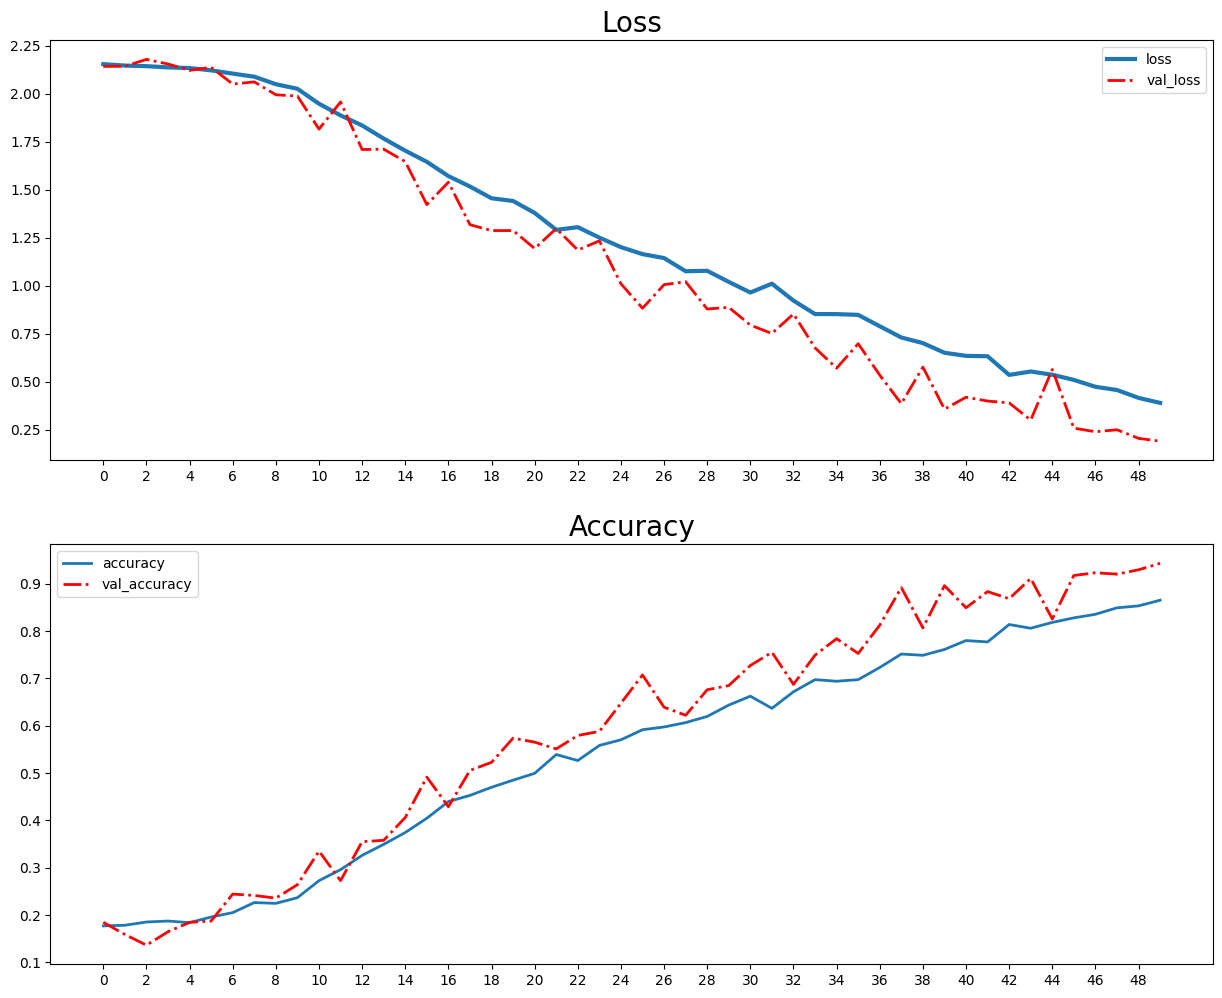

In [8]:
# Define a X variable to store range of epochs
x = np.arange(len(result_df))

# Create a plot with 3 row and 1 col with size of (15, 12)
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)                          
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].set_xticks(np.arange(0, len(x), 2))
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].set_xticks(np.arange(0, len(x), 2))
ax[1].legend()

# #  AX2 : Loss
# ax[2].plot(x, result_df.learning_rate, label='learning_rate', linewidth=2, marker='o')
# ax[2].set_title('learning_rate', fontsize=20)
# ax[2].set_xlabel('epochs')
# ax[2].set_xticks(np.arange(0, len(x), 2))
# ax[2].legend()

plt.show()

In [9]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it by keras.models.load_model
# best_model = tf.keras.models.load_model('MyModel.keras')

In [10]:
# Evaluate model by model.evaluate()
loss, accuracy = model.evaluate(test_ds)
print()
print(f'Loss : {loss}')
print(f'Accuracy : {accuracy*100}%')

24/24 [==============================] - 6s 240ms/step - loss: 1.5790 - accuracy: 0.5780

Loss : 1.579028606414795
Accuracy : 57.79569745063782%


In [11]:
model.save("AlexNet_model.keras")